# 04. Cross-Validation and Model Selection
## Walk-Forward Analysis for Time Series

This notebook implements proper time series cross-validation to avoid lookahead bias.

### Key Concepts:
1. **Walk-Forward Validation**: Train on expanding windows
2. **Purging**: Remove overlapping samples
3. **Embargo**: Add gap between train and test
4. **Combinatorial Purged Cross-Validation**: Advanced technique for financial data

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

print("Libraries imported successfully!")

root_folder = '../'  # Define the root folder for saving files

Libraries imported successfully!


## 1. Load Data

In [12]:
# Load data
X_all = pd.read_csv(f'{root_folder}data/processed/engineered_features1.csv')
y = pd.read_csv(f'{root_folder}data/processed/aligned_targets1.csv').squeeze()

# Load feature sets
with open(f'{root_folder}data/processed/feature_sets1.json', 'r') as f:
    feature_sets = json.load(f)

# Use best feature set from previous analysis
feature_set = feature_sets['union']
X_selected = X_all[feature_set]

print(f"Data shape: {X_selected.shape}")
print(f"Using {len(feature_set)} selected features")

Data shape: (1499, 82)
Using 82 selected features


## 2. Walk-Forward Cross-Validation Implementation

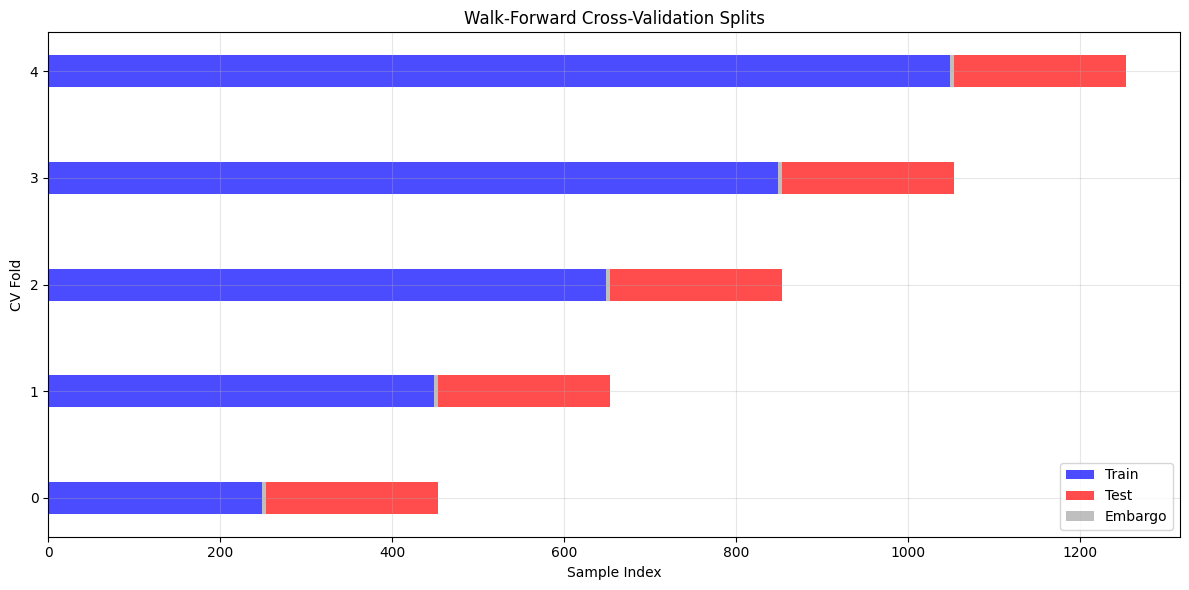


Number of CV splits: 5


In [13]:
class WalkForwardCV:
    """Walk-forward cross-validation with purging and embargo."""
    
    def __init__(self, n_splits=5, test_size=90, embargo=1, expanding=True):
        self.n_splits = n_splits
        self.test_size = test_size
        self.embargo = embargo
        self.expanding = expanding
    
    def split(self, X, y=None):
        """Generate train/test splits."""
        n_samples = len(X)
        
        # Calculate initial train size
        min_train_size = max(100, n_samples // (self.n_splits + 1))
        
        for i in range(self.n_splits):
            if self.expanding:
                # Expanding window
                train_start = 0
                train_end = min_train_size + i * self.test_size
            else:
                # Rolling window
                train_start = max(0, i * self.test_size)
                train_end = min_train_size + i * self.test_size
            
            # Apply embargo
            test_start = train_end + self.embargo
            test_end = min(test_start + self.test_size, n_samples)
            
            if test_end > n_samples or test_start >= n_samples:
                break
            
            train_idx = np.arange(train_start, train_end)
            test_idx = np.arange(test_start, test_end)
            
            yield train_idx, test_idx
    
    def plot_splits(self, X):
        """Visualize the CV splits."""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (train_idx, test_idx) in enumerate(self.split(X)):
            # Plot train
            ax.barh(i, len(train_idx), left=train_idx[0], height=0.3, 
                   color='blue', alpha=0.7, label='Train' if i == 0 else '')
            # Plot test
            ax.barh(i, len(test_idx), left=test_idx[0], height=0.3, 
                   color='red', alpha=0.7, label='Test' if i == 0 else '')
            # Plot embargo
            if self.embargo > 0:
                embargo_start = train_idx[-1] + 1
                ax.barh(i, self.embargo, left=embargo_start, height=0.3, 
                       color='gray', alpha=0.5, label='Embargo' if i == 0 else '')
        
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('CV Fold')
        ax.set_title('Walk-Forward Cross-Validation Splits')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Create and visualize CV splits
cv = WalkForwardCV(n_splits=5, test_size=200, embargo=5, expanding=True)
cv.plot_splits(X_selected)

# Count actual splits
n_actual_splits = sum(1 for _ in cv.split(X_selected))
print(f"\nNumber of CV splits: {n_actual_splits}")

## 3. Cross-Validation Function

In [14]:
def cross_validate_model(model, X, y, cv, return_predictions=False):
    """Perform cross-validation and return metrics."""

    fold_metrics = []
    all_predictions = []
    all_actuals = []
    all_indices = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
        # Split data
        X_train_fold = X.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        # Train model
        if hasattr(model, 'fit'):
            if isinstance(model, (xgb.XGBRegressor, lgb.LGBMRegressor)):
                # For XGBoost and LightGBM, try to use early stopping if supported
                try:
                    model.fit(
                        X_train_scaled, y_train_fold,
                        eval_set=[(X_test_scaled, y_test_fold)],
                        early_stopping_rounds=20,
                        verbose=False,
                    )
                except TypeError:
                    # Fallback: some versions/wrappers don't accept these kwargs
                    try:
                        model.fit(X_train_scaled, y_train_fold, eval_set=[(X_test_scaled, y_test_fold)])
                    except TypeError:
                        model.fit(X_train_scaled, y_train_fold)
            else:
                model.fit(X_train_scaled, y_train_fold)

        # Make predictions
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(y_test_fold, y_pred)
        rmse = np.sqrt(mse)

        # Direction accuracy
        direction_acc = np.mean(np.sign(y_test_fold) == np.sign(y_pred))

        # Information coefficient
        from scipy.stats import spearmanr
        ic, _ = spearmanr(y_test_fold, y_pred)

        # Store metrics
        fold_metrics.append({
            'fold': fold,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'mse': mse,
            'rmse': rmse,
            'direction_acc': direction_acc,
            'ic': ic
        })

        if return_predictions:
            # Ensure predictions and actuals are flat lists/arrays
            all_predictions.extend(np.asarray(y_pred).ravel().tolist())
            all_actuals.extend(np.asarray(y_test_fold).ravel().tolist())
            all_indices.extend(test_idx.tolist())

    # Calculate average metrics
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df[['mse', 'rmse', 'direction_acc', 'ic']].mean()
    std_metrics = metrics_df[['mse', 'rmse', 'direction_acc', 'ic']].std()

    results = {
        'fold_metrics': metrics_df,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics
    }

    if return_predictions:
        results['predictions'] = np.array(all_predictions)
        results['actuals'] = np.array(all_actuals)
        results['indices'] = np.array(all_indices)

    return results

## 4. Model Cross-Validation

In [15]:
# Define models to evaluate
models = {
    'Ridge': Ridge(alpha=10.0, random_state=42),
    
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=7,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    ),
    
    'XGBoost': xgb.XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

# Run cross-validation for each model
cv_results = {}

print("Running cross-validation for each model...\n")
print("="*60)

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    results = cross_validate_model(
        model, X_selected, y, cv, 
        return_predictions=True
    )
    
    cv_results[model_name] = results
    
    # Print summary
    print(f"\nAverage Metrics:")
    for metric, value in results['avg_metrics'].items():
        std = results['std_metrics'][metric]
        print(f"  {metric:15s}: {value:.6f} ± {std:.6f}")
    
    # Print fold details
    print(f"\nFold-by-fold results:")
    print(results['fold_metrics'][['fold', 'rmse', 'direction_acc', 'ic']].round(4))
    print("="*60)

Running cross-validation for each model...


Evaluating Ridge...

Average Metrics:
  mse            : 0.000105 ± 0.000130
  rmse           : 0.009026 ± 0.005391
  direction_acc  : 0.563000 ± 0.033838
  ic             : 0.209159 ± 0.051926

Fold-by-fold results:
   fold    rmse  direction_acc      ic
0     0  0.0066          0.515  0.1887
1     1  0.0054          0.550  0.2214
2     2  0.0056          0.590  0.2774
3     3  0.0183          0.560  0.2225
4     4  0.0092          0.600  0.1358

Evaluating RandomForest...

Average Metrics:
  mse            : 0.000033 ± 0.000004
  rmse           : 0.005692 ± 0.000366
  direction_acc  : 0.564000 ± 0.070125
  ic             : 0.250492 ± 0.075999

Fold-by-fold results:
   fold    rmse  direction_acc      ic
0     0  0.0062          0.490  0.1633
1     1  0.0057          0.485  0.1732
2     2  0.0055          0.620  0.3183
3     3  0.0059          0.605  0.3104
4     4  0.0053          0.620  0.2872

Evaluating XGBoost...
[0]	validation_0-rmse:

## 5. Model Comparison Visualization

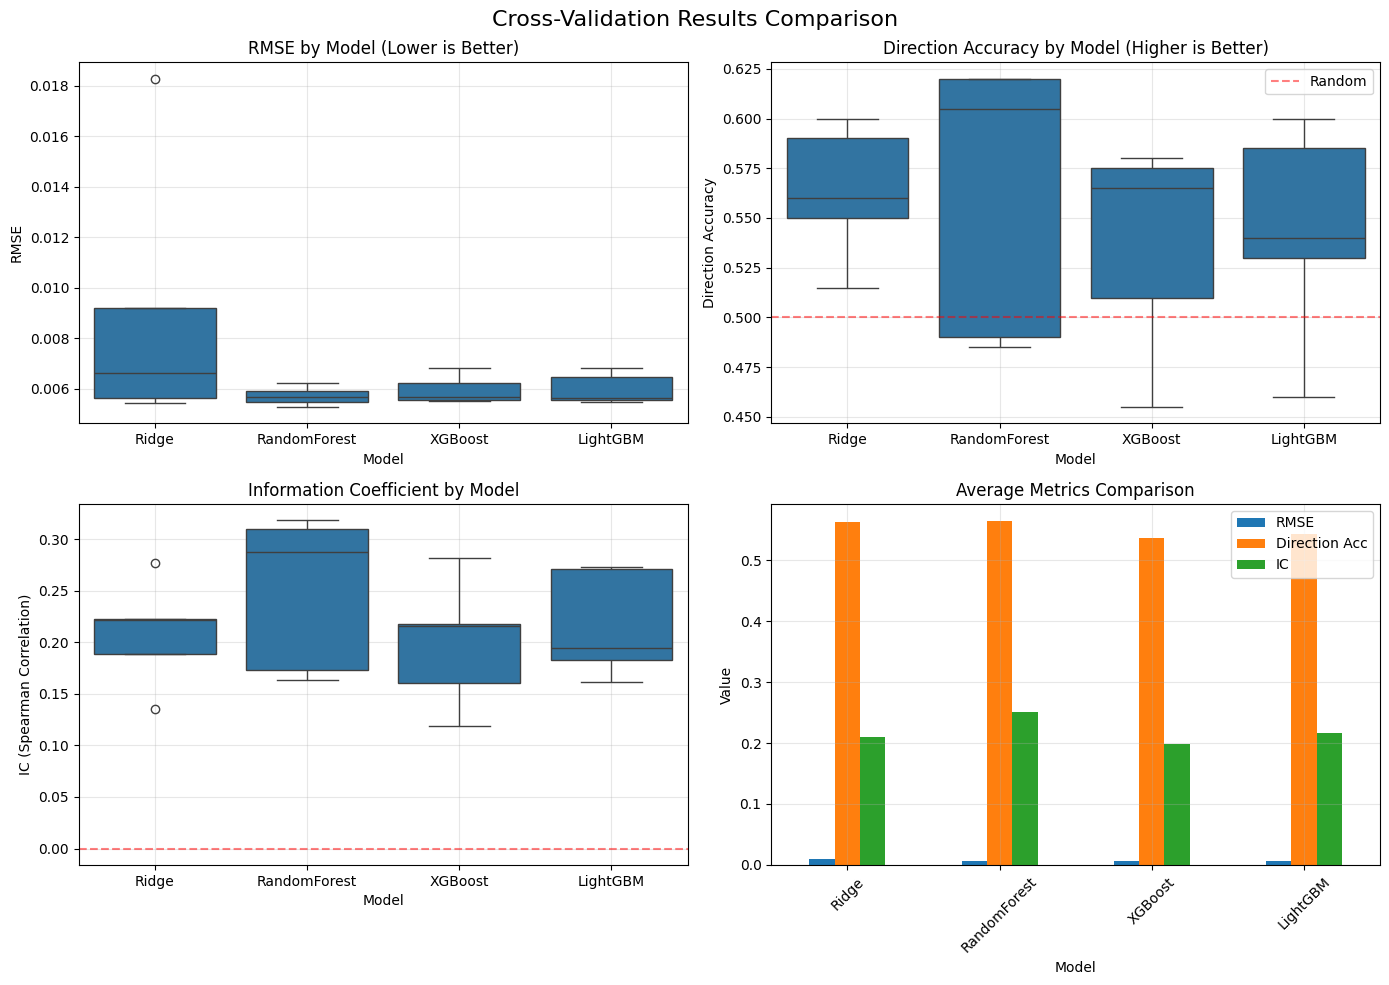

In [16]:
# Aggregate CV results
comparison_data = []
for model_name, results in cv_results.items():
    for _, row in results['fold_metrics'].iterrows():
        comparison_data.append({
            'Model': model_name,
            'Fold': row['fold'],
            'RMSE': row['rmse'],
            'Direction_Acc': row['direction_acc'],
            'IC': row['ic']
        })

comparison_df = pd.DataFrame(comparison_data)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE comparison
sns.boxplot(data=comparison_df, x='Model', y='RMSE', ax=axes[0, 0])
axes[0, 0].set_title('RMSE by Model (Lower is Better)')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].grid(True, alpha=0.3)

# Direction Accuracy comparison
sns.boxplot(data=comparison_df, x='Model', y='Direction_Acc', ax=axes[0, 1])
axes[0, 1].set_title('Direction Accuracy by Model (Higher is Better)')
axes[0, 1].set_ylabel('Direction Accuracy')
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# IC comparison
sns.boxplot(data=comparison_df, x='Model', y='IC', ax=axes[1, 0])
axes[1, 0].set_title('Information Coefficient by Model')
axes[1, 0].set_ylabel('IC (Spearman Correlation)')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Average metrics comparison
avg_metrics_comparison = pd.DataFrame({
    model: results['avg_metrics'] 
    for model, results in cv_results.items()
}).T

avg_metrics_comparison[['rmse', 'direction_acc', 'ic']].plot(
    kind='bar', ax=axes[1, 1]
)
axes[1, 1].set_title('Average Metrics Comparison')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend(['RMSE', 'Direction Acc', 'IC'])
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

plt.suptitle('Cross-Validation Results Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Stability Analysis

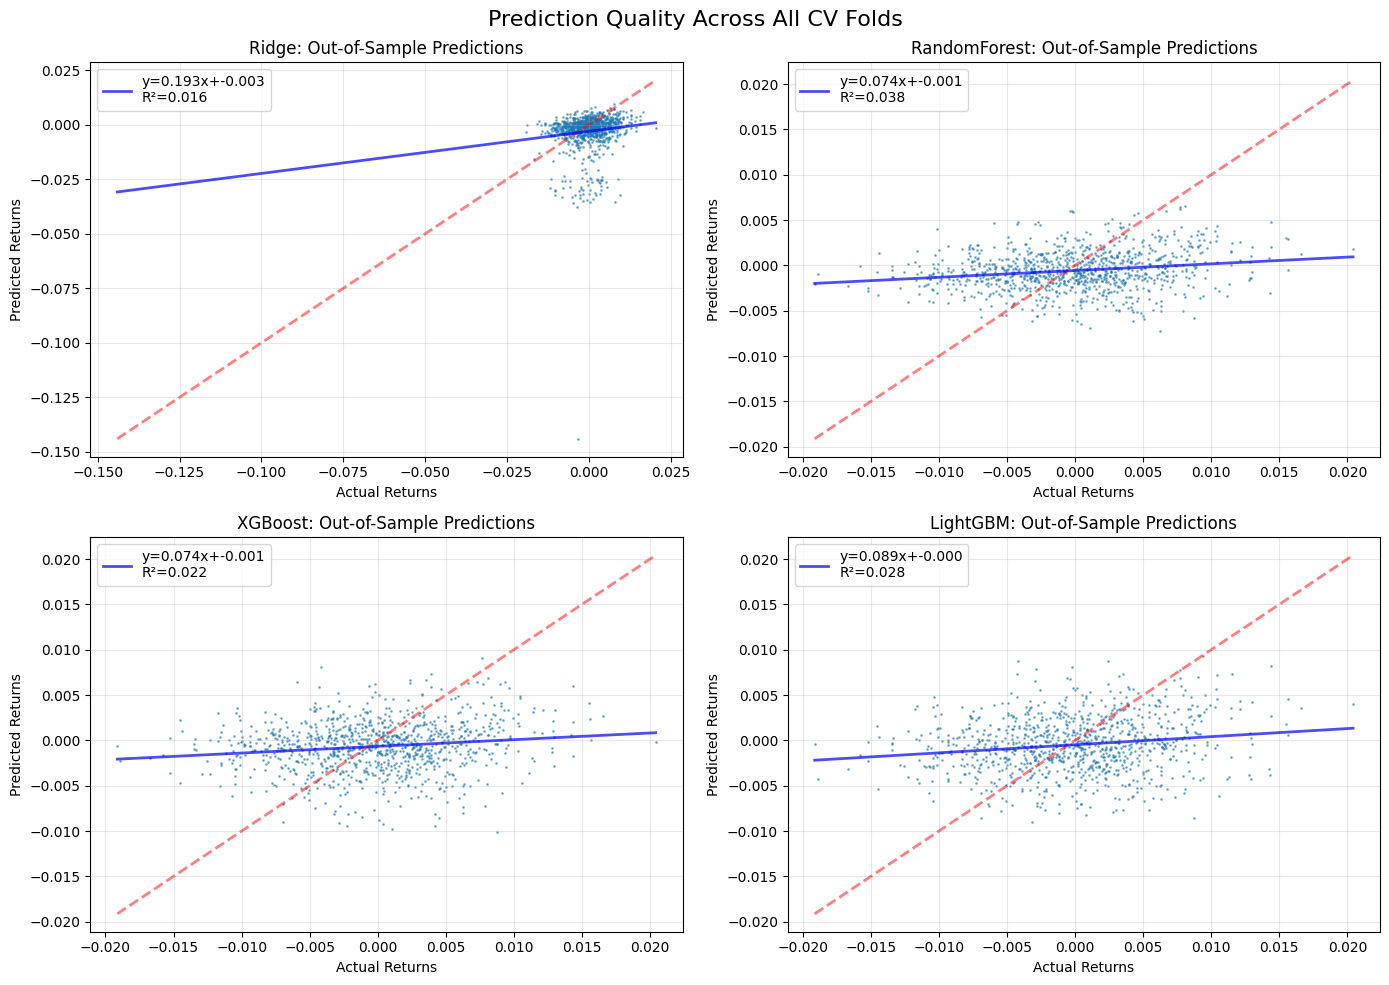

In [17]:
# Analyze prediction stability across folds
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (model_name, results) in enumerate(cv_results.items()):
    if idx >= 4:
        break
    
    predictions = results['predictions']
    actuals = results['actuals']
    
    # Scatter plot of predictions vs actuals
    axes[idx].scatter(actuals, predictions, alpha=0.5, s=1)
    
    # Add diagonal line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.5)
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, _, _ = stats.linregress(actuals, predictions)
    x_line = np.array([min_val, max_val])
    y_line = slope * x_line + intercept
    axes[idx].plot(x_line, y_line, 'b-', lw=2, alpha=0.7, 
                  label=f'y={slope:.3f}x+{intercept:.3f}\nR²={r_value**2:.3f}')
    
    axes[idx].set_xlabel('Actual Returns')
    axes[idx].set_ylabel('Predicted Returns')
    axes[idx].set_title(f'{model_name}: Out-of-Sample Predictions')
    axes[idx].legend(loc='upper left')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Prediction Quality Across All CV Folds', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Statistical Significance Testing

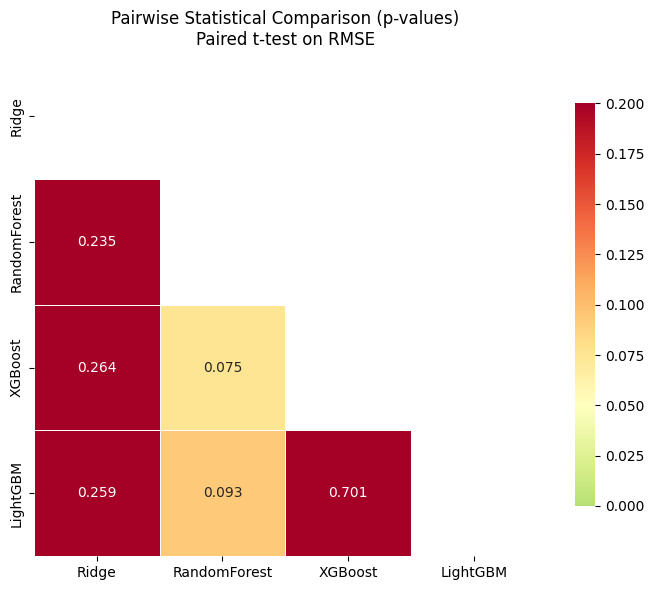

Statistical Significance (p < 0.05):


In [18]:
# Perform statistical tests to compare models
from scipy import stats

def compare_models_statistically(cv_results):
    """Perform pairwise statistical tests between models."""

    model_names = list(cv_results.keys())
    n_models = len(model_names)

    # Create comparison matrix for RMSE
    p_values = np.ones((n_models, n_models))

    for i in range(n_models):
        for j in range(i+1, n_models):
            model1 = model_names[i]
            model2 = model_names[j]

            # Get RMSE values for each fold
            rmse1 = cv_results[model1]['fold_metrics']['rmse'].values
            rmse2 = cv_results[model2]['fold_metrics']['rmse'].values

            # Paired t-test (since same folds)
            t_stat, p_value = stats.ttest_rel(rmse1, rmse2)

            p_values[i, j] = p_value
            p_values[j, i] = p_value

    # Create DataFrame
    p_values_df = pd.DataFrame(p_values, index=model_names, columns=model_names)

    return p_values_df

# Perform comparison
p_values_df = compare_models_statistically(cv_results)

# Visualize p-values
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(p_values_df, dtype=bool))
sns.heatmap(p_values_df, mask=mask, annot=True, fmt='.3f', 
            cmap='RdYlGn_r', center=0.05, vmin=0, vmax=0.2,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Pairwise Statistical Comparison (p-values)\nPaired t-test on RMSE')
plt.tight_layout()
plt.show()

print("Statistical Significance (p < 0.05):")
print("="*50)
# Ensure model_names is defined for this reporting loop
model_names = list(cv_results.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        p_val = p_values_df.iloc[i, j]
        if p_val < 0.05:
            model1 = model_names[i]
            model2 = model_names[j]
            avg_rmse1 = cv_results[model1]['avg_metrics']['rmse']
            avg_rmse2 = cv_results[model2]['avg_metrics']['rmse']
            better = model1 if avg_rmse1 < avg_rmse2 else model2
            print(f"{model1} vs {model2}: p={p_val:.4f} - {better} is significantly better")

## 8. Best Model Selection

In [19]:
# Rank models by multiple criteria
ranking_data = []

for model_name, results in cv_results.items():
    avg_metrics = results['avg_metrics']
    std_metrics = results['std_metrics']
    
    # Calculate composite score (lower is better)
    # Weighted combination of normalized metrics
    composite_score = (
        avg_metrics['rmse'] * 1.0 +  # Lower is better
        (1 - avg_metrics['direction_acc']) * 0.5 +  # Higher is better, so invert
        (1 - avg_metrics['ic']) * 0.3 +  # Higher is better, so invert
        std_metrics['rmse'] * 0.2  # Penalize high variance
    )
    
    ranking_data.append({
        'Model': model_name,
        'Avg_RMSE': avg_metrics['rmse'],
        'Std_RMSE': std_metrics['rmse'],
        'Avg_Direction_Acc': avg_metrics['direction_acc'],
        'Avg_IC': avg_metrics['ic'],
        'Composite_Score': composite_score
    })

ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Composite_Score')
ranking_df['Rank'] = range(1, len(ranking_df) + 1)

print("\nModel Ranking (Cross-Validation Performance)")
print("="*80)
print(ranking_df.set_index('Rank').round(4))

best_model = ranking_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*80}")
print(f"Average RMSE: {ranking_df.iloc[0]['Avg_RMSE']:.6f}")
print(f"Direction Accuracy: {ranking_df.iloc[0]['Avg_Direction_Acc']:.4f}")
print(f"Information Coefficient: {ranking_df.iloc[0]['Avg_IC']:.4f}")


Model Ranking (Cross-Validation Performance)
             Model  Avg_RMSE  Std_RMSE  Avg_Direction_Acc  Avg_IC  \
Rank                                                                
1     RandomForest    0.0057    0.0004              0.564  0.2505   
2            Ridge    0.0090    0.0054              0.563  0.2092   
3         LightGBM    0.0060    0.0006              0.543  0.2165   
4          XGBoost    0.0060    0.0006              0.537  0.1990   

      Composite_Score  
Rank                   
1              0.4486  
2              0.4659  
3              0.4697  
4              0.4779  

BEST MODEL: RandomForest
Average RMSE: 0.005692
Direction Accuracy: 0.5640
Information Coefficient: 0.2505


## 9. Save Cross-Validation Results

In [20]:
# Save CV results
import pickle

# Save full CV results
with open(f'{root_folder}data/results/cv_results1.pkl', 'wb') as f:
    pickle.dump(cv_results, f)
print("✓ Saved full CV results")

# Save ranking
ranking_df.to_csv(f'{root_folder}data/results/model_ranking_cv1.csv', index=False)
print("✓ Saved model ranking")

# Save best model selection
best_model_info = {
    'model_name': best_model,
    'avg_metrics': cv_results[best_model]['avg_metrics'].to_dict(),
    'std_metrics': cv_results[best_model]['std_metrics'].to_dict(),
    'feature_set': feature_set,
    'cv_params': {
        'n_splits': cv.n_splits,
        'test_size': cv.test_size,
        'embargo': cv.embargo,
        'expanding': cv.expanding
    }
}

with open(f'{root_folder}data/results/best_model_cv1.json', 'w') as f:
    json.dump(best_model_info, f, indent=2)
print("✓ Saved best model information")

print("\nCross-validation complete!")
print(f"Best model ({best_model}) selected for backtesting.")

✓ Saved full CV results
✓ Saved model ranking
✓ Saved best model information

Cross-validation complete!
Best model (RandomForest) selected for backtesting.
